# Using MITGCM data

In this example we will generate structure functions from MITGCM ECCO data. 

**General procedure:**

1. Load data
2. Format data
3. Calculate structure functions
4. Plot structure functions

External modules used in this example include

- `ecco_v4_py`
- `seaborn`: optional

In [32]:
import warnings

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import xarray as xr
from geopy.distance import great_circle

import fluidsf

warnings.filterwarnings("ignore")  # Ignore warnings for the purpose of this tutorial

sns.set_style(style="white")
sns.set_context("talk")
matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

In [141]:
ds = xr.open_dataset(
    "/Volumes/Promise Disk/data/mitgcm/acc_data/LLC4320_pre-SWOT_ACC_SMST_20111213.nc"
)

In [142]:
ds = ds.isel(time=0, k=0)

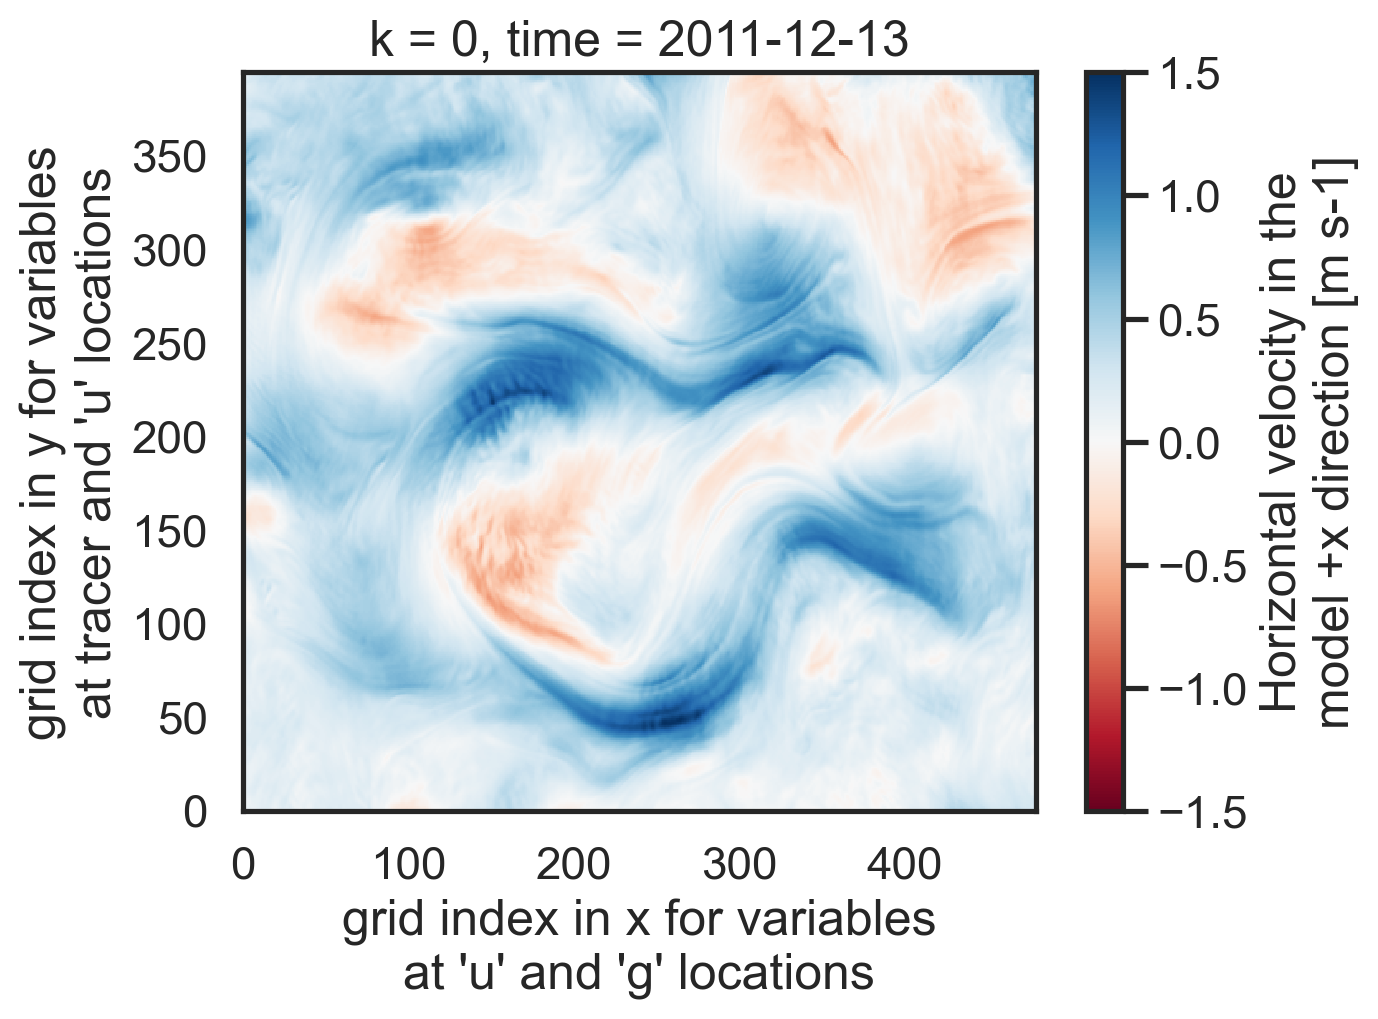

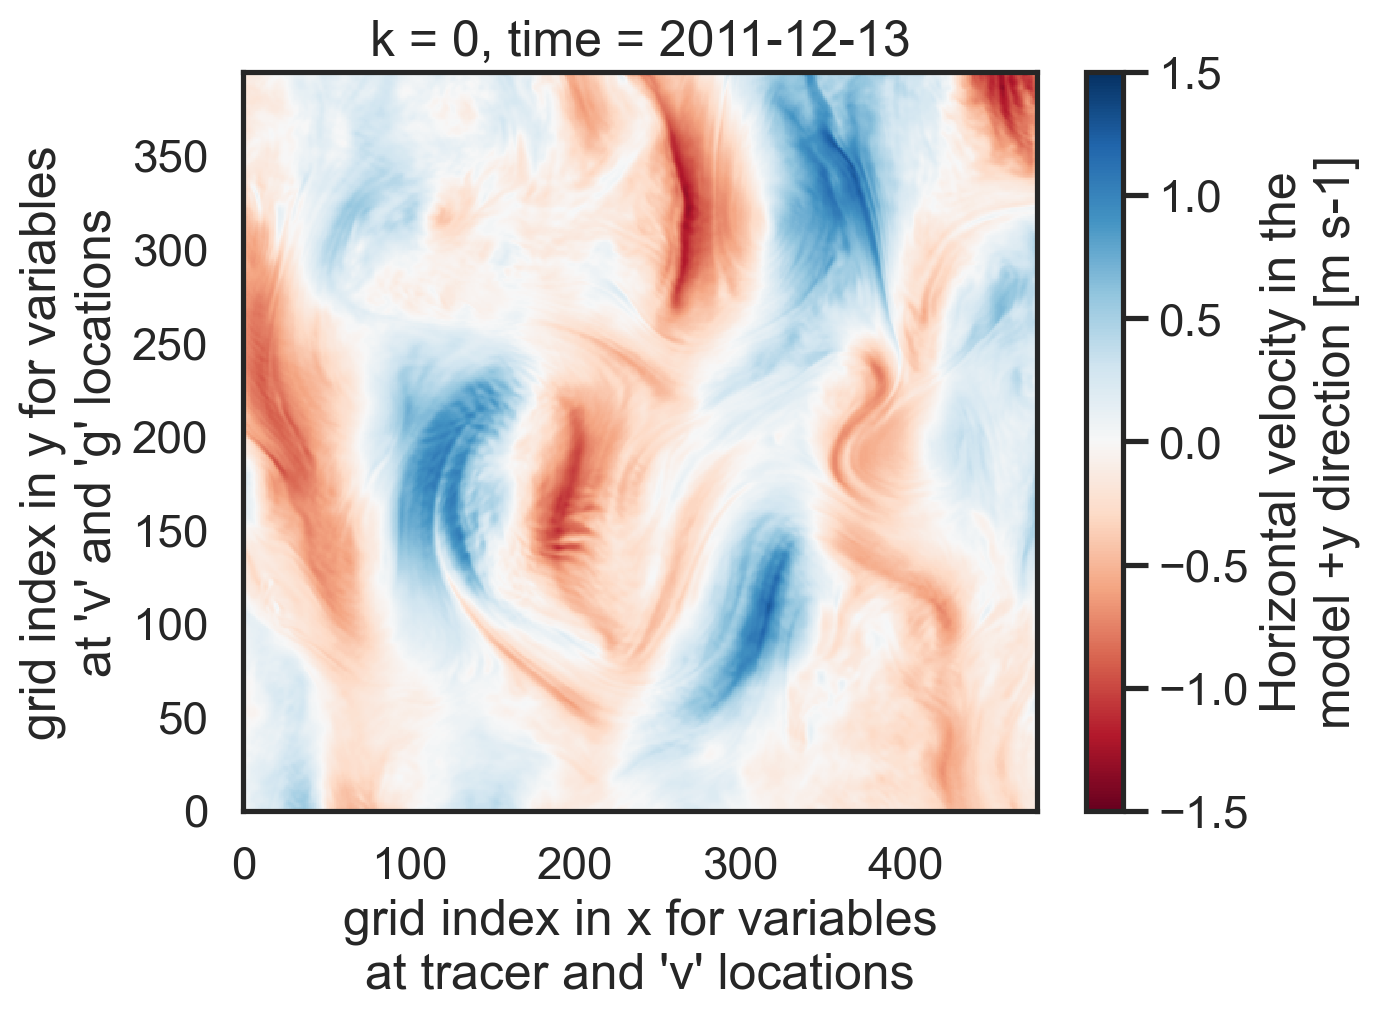

In [75]:
ds.U.plot.pcolormesh(cmap="RdBu",vmin=-1.5,vmax=1.5)
plt.show()

ds.V.plot.pcolormesh(cmap="RdBu",vmin=-1.5,vmax=1.5)
plt.show()

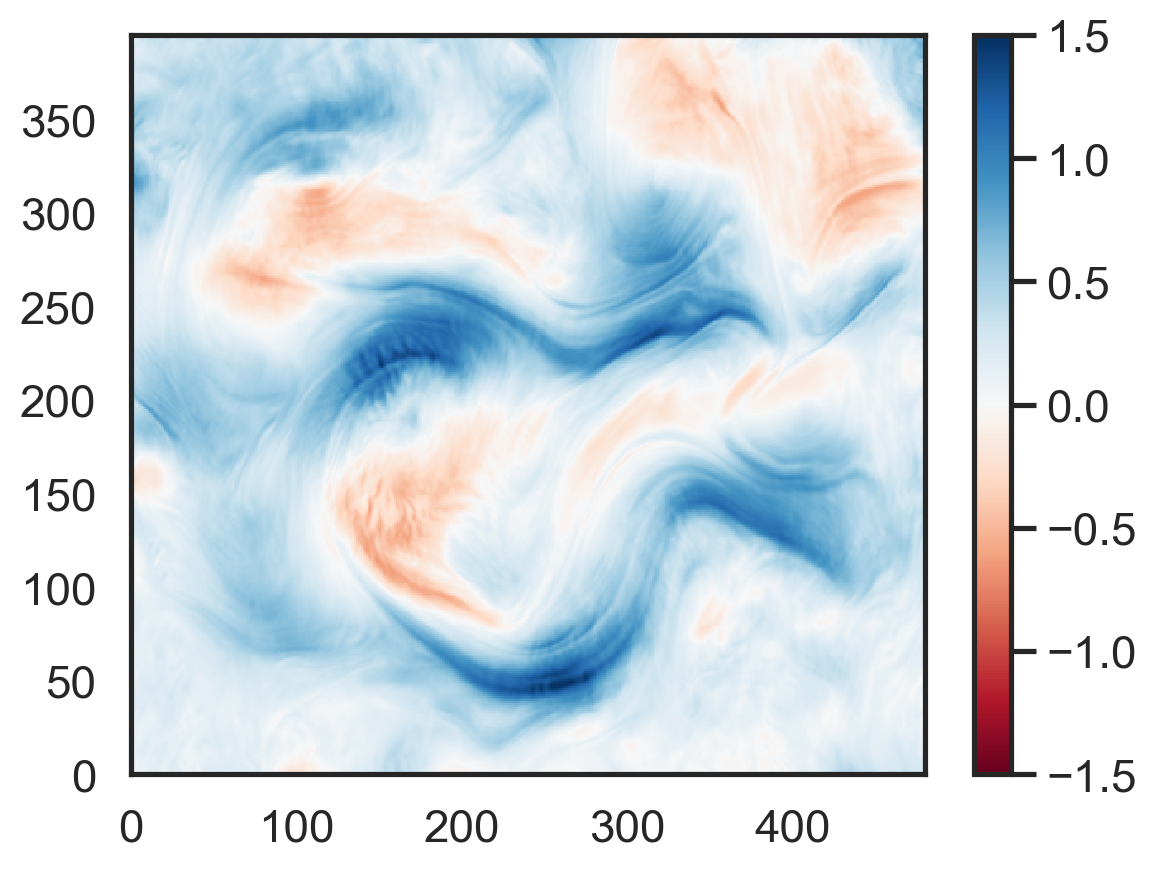

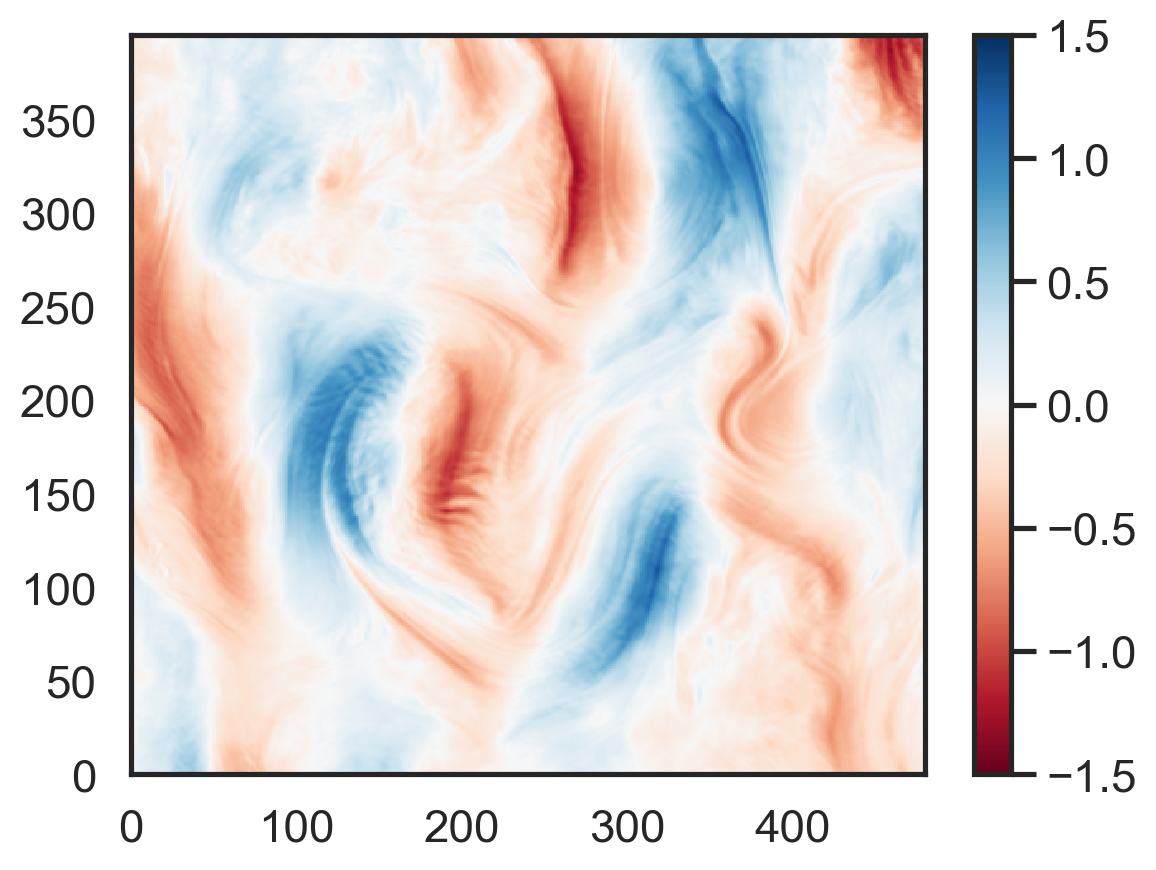

In [73]:
U_east = ds.AngleCS.values * ds.U.values - ds.AngleSN.values * ds.V.values
V_north = ds.AngleSN.values * ds.U.values + ds.AngleCS.values * ds.V.values

plt.pcolormesh(U_east, cmap="RdBu",vmin=-1.5,vmax=1.5)
plt.colorbar()
plt.show()

plt.pcolormesh(V_north, cmap="RdBu",vmin=-1.5,vmax=1.5)
plt.colorbar()
plt.show()

In [234]:
sf_uniform = fluidsf.generate_structure_functions(
    ds.U.values,
    ds.V.values,
    ds.j_g.values*ds.DXC.values[:,0],
    ds.i_g.values*ds.DYC.values[0,:],
    sf_type=["ASF_V", "LLL"],
    boundary=None,
)

sf_uniform_ue_vn = fluidsf.generate_structure_functions(
    U_east,
    V_north,
    ds.j_g.values*ds.DXC.values[:,0],
    ds.i_g.values*ds.DYC.values[0,:],
    sf_type=["ASF_V", "LLL"],
    boundary=None,
)

In [241]:
sf_nonuniform_uv = fluidsf.generate_structure_functions(
    ds.U.values,
    ds.V.values,
    y=ds.XC.values[0,:],
    x=ds.YC.values[:,0],
    sf_type=["ASF_V", "LLL"],
    boundary=None,
    dx=ds.DXC.values[0,:],
    dy=ds.DYC.values[:,0],
    grid_type="latlon",
)

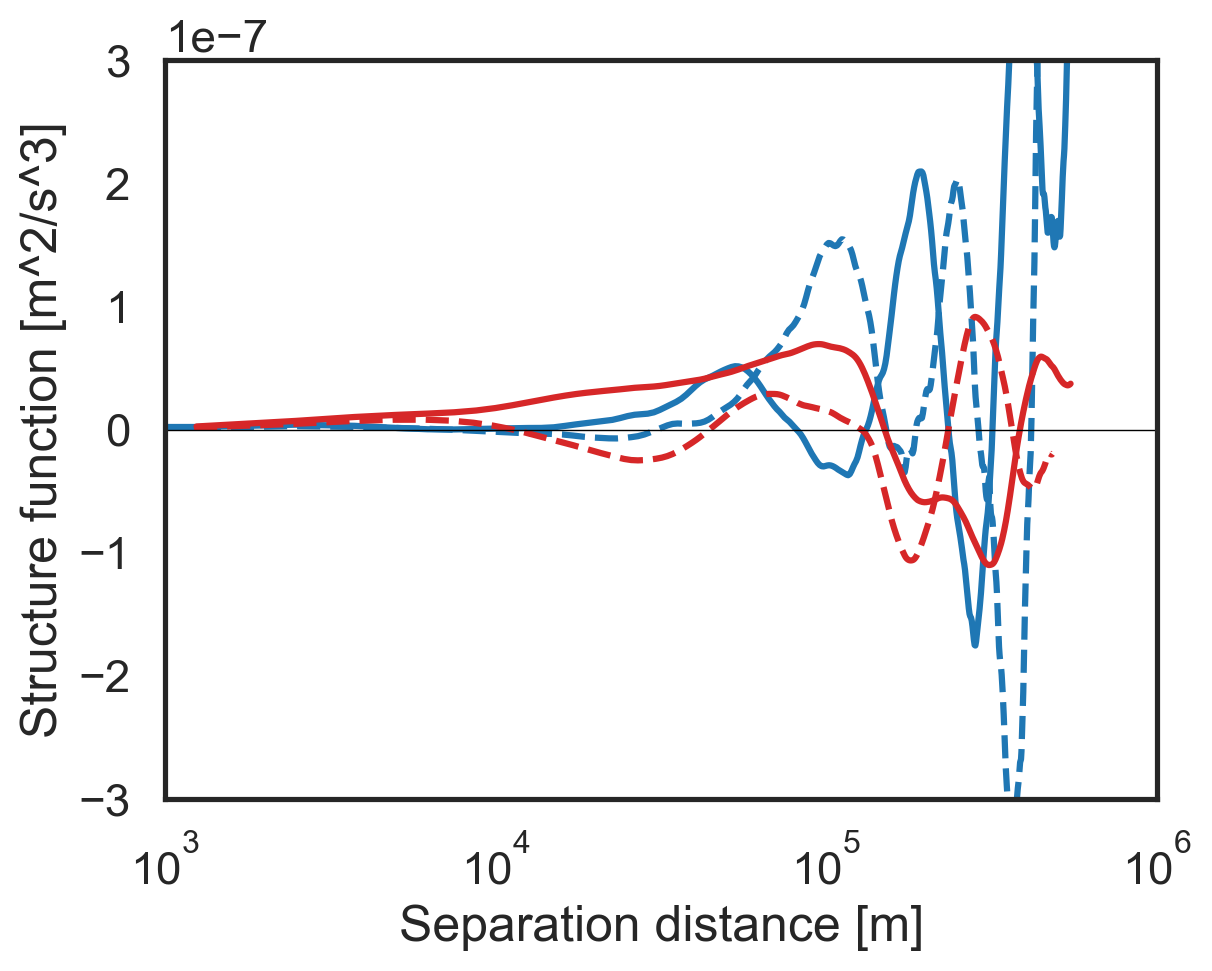

In [82]:
plt.semilogx(
    sf_uniform["x-diffs"], -sf_uniform["SF_advection_velocity_x"] / 2, color="tab:blue"
)
plt.semilogx(
    sf_uniform["y-diffs"],
    -sf_uniform["SF_advection_velocity_y"] / 2,
    color="tab:blue",
    linestyle="--",
)
plt.semilogx(
    sf_uniform["x-diffs"],
    -2 * sf_uniform["SF_LLL_x"] / (3 * sf_uniform["x-diffs"]),
    color="tab:red",
)
plt.semilogx(
    sf_uniform["y-diffs"],
    -2 * sf_uniform["SF_LLL_y"] / 3 / sf_uniform["y-diffs"],
    color="tab:red",
    linestyle="--",
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 3e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

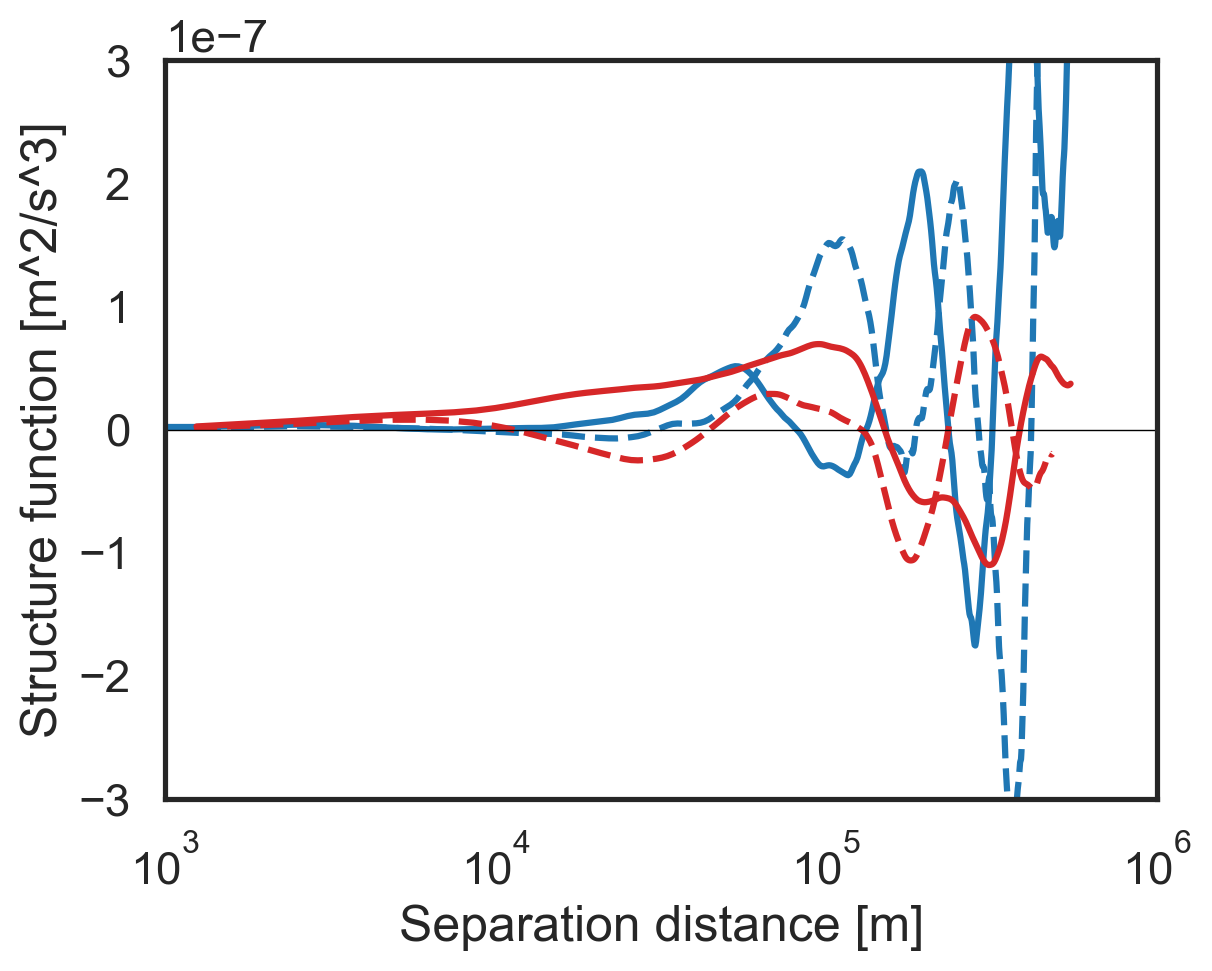

In [81]:
plt.semilogx(
    sf_uniform_ue_vn["x-diffs"],
    -sf_uniform_ue_vn["SF_advection_velocity_x"] / 2,
    color="tab:blue",
)
plt.semilogx(
    sf_uniform_ue_vn["y-diffs"],
    -sf_uniform_ue_vn["SF_advection_velocity_y"] / 2,
    color="tab:blue",
    linestyle="--",
)
plt.semilogx(
    sf_uniform_ue_vn["x-diffs"],
    -2 * sf_uniform_ue_vn["SF_LLL_x"] / (3 * sf_uniform_ue_vn["x-diffs"]),
    color="tab:red",
)
plt.semilogx(
    sf_uniform_ue_vn["y-diffs"],
    -2 * sf_uniform_ue_vn["SF_LLL_y"] / 3 / sf_uniform_ue_vn["y-diffs"],
    color="tab:red",
    linestyle="--",
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 3e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

In [147]:
ssa = ds.Eta.values

xd = np.asarray(
    [
        np.abs(
            great_circle(
                (ds.YC[:, 0].values[i + 1], ds.XC[:, 0].values[i + 1]),
                (ds.YC[:, 0].values[i], ds.XC[:, 0].values[i]),
            ).meters
        )
        for i in range(-1, len(ds.XC[:, 0].values) - 1)
    ]
)
yd = np.asarray(
    [
        np.abs(
            great_circle(
                (ds.YC[0, :].values[i + 1], ds.XC[0, :].values[i + 1]),
                (ds.YC[0, :].values[i], ds.XC[0, :].values[i]),
            ).meters
        )
        for i in range(-1, len(ds.YC[0, :].values) - 1)
    ]
)

xd[0] = 0
yd[0] = 0

omega = 7.2921e-5
g = 9.81
detadx, detady = np.gradient(ssa, yd.cumsum(), xd.cumsum(), axis=(1, 0))
U = -(g / (2 * omega * np.sin(ds.YC * np.pi / 180))) * detady
V = (g / (2 * omega * np.sin(ds.YC * np.pi / 180))) * detadx

dudx, dudy = np.gradient(U, yd.cumsum(), xd.cumsum(), axis=(1, 0))
dvdx, dvdy = np.gradient(V, yd.cumsum(), xd.cumsum(), axis=(1, 0))

W = dvdx - dudy

lons = ds.XC.values[0, :]
lats = ds.YC.values[:, 0]

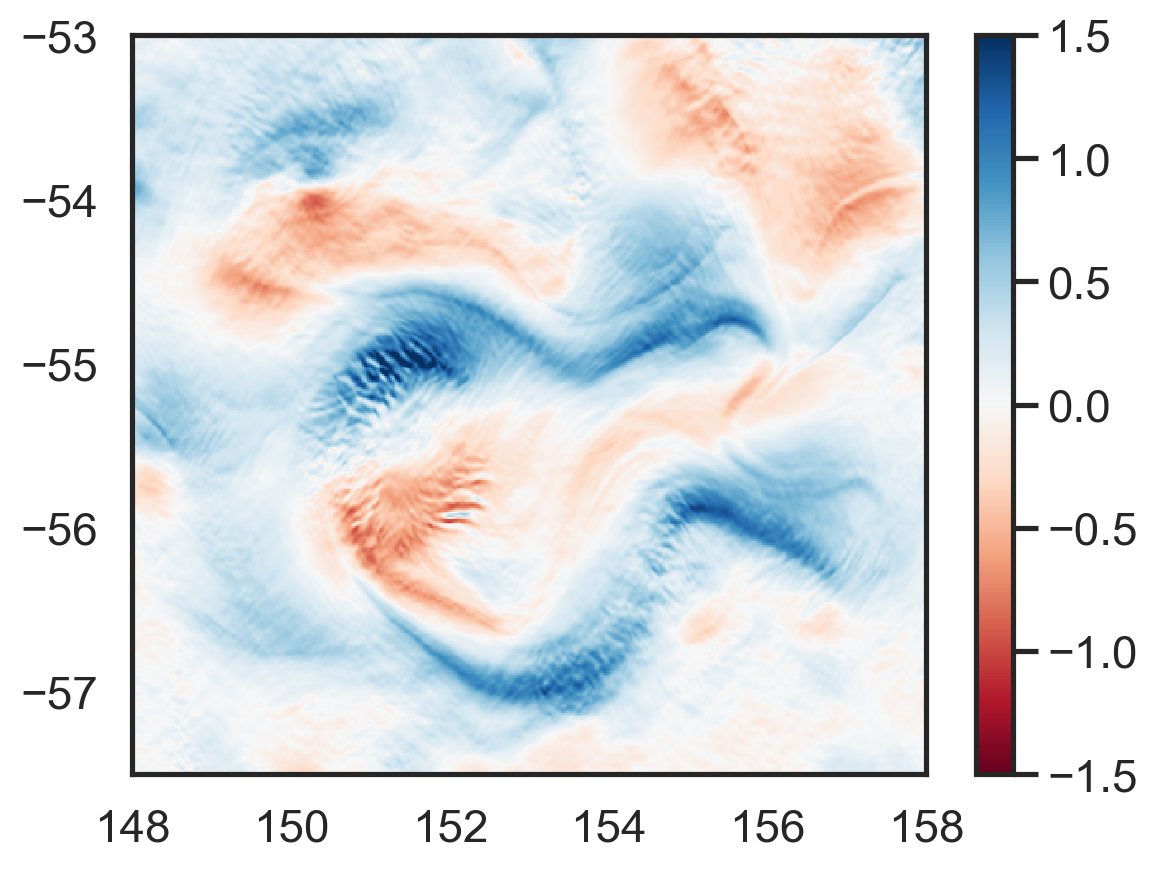

In [68]:
plt.pcolormesh(lons, lats, U, cmap="RdBu",vmin=-1.5,vmax=1.5)
plt.colorbar()

In [118]:
sfs = fluidsf.generate_structure_functions(
    U,
    V,
    lats,
    lons,
    dx=yd,
    dy=xd,
    sf_type=["LLL"],
    boundary=None,
    grid_type="latlon",
)

ValueError: If grid_type is 'latlon', dx and dy must be provided as arrays.

In [236]:
sf_geostrophic_uniform = fluidsf.generate_structure_functions(
    U,
    V,
    ds.j_g.values*ds.DXC.values[:,0],
    ds.i_g.values*ds.DYC.values[0,:],
    sf_type=["ASF_V", "LLL"],
    boundary=None,
)

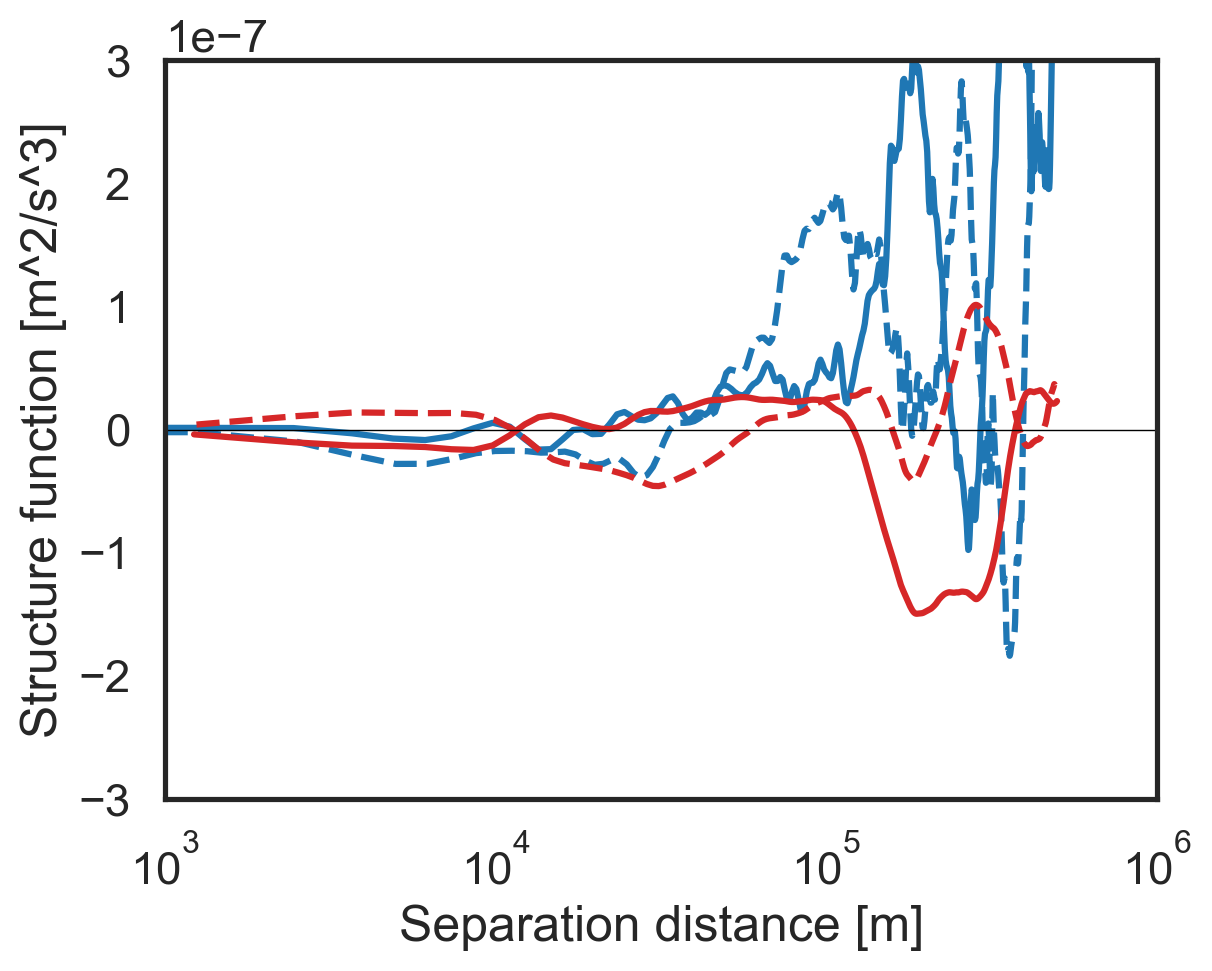

In [88]:
plt.semilogx(
    sfs["x-diffs"], -sfs["SF_advection_velocity_x"] / 2, color="tab:blue"
)
plt.semilogx(
    sfs["y-diffs"],
    -sfs["SF_advection_velocity_y"] / 2,
    color="tab:blue",
    linestyle="--",
)
plt.semilogx(
    sfs["x-diffs"],
    -2 * sfs["SF_LLL_x"] / (3 * sfs["x-diffs"]),
    color="tab:red",
)
plt.semilogx(
    sfs["y-diffs"],
    -2 * sfs["SF_LLL_y"] / 3 / sfs["y-diffs"],
    color="tab:red",
    linestyle="--",
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 3e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

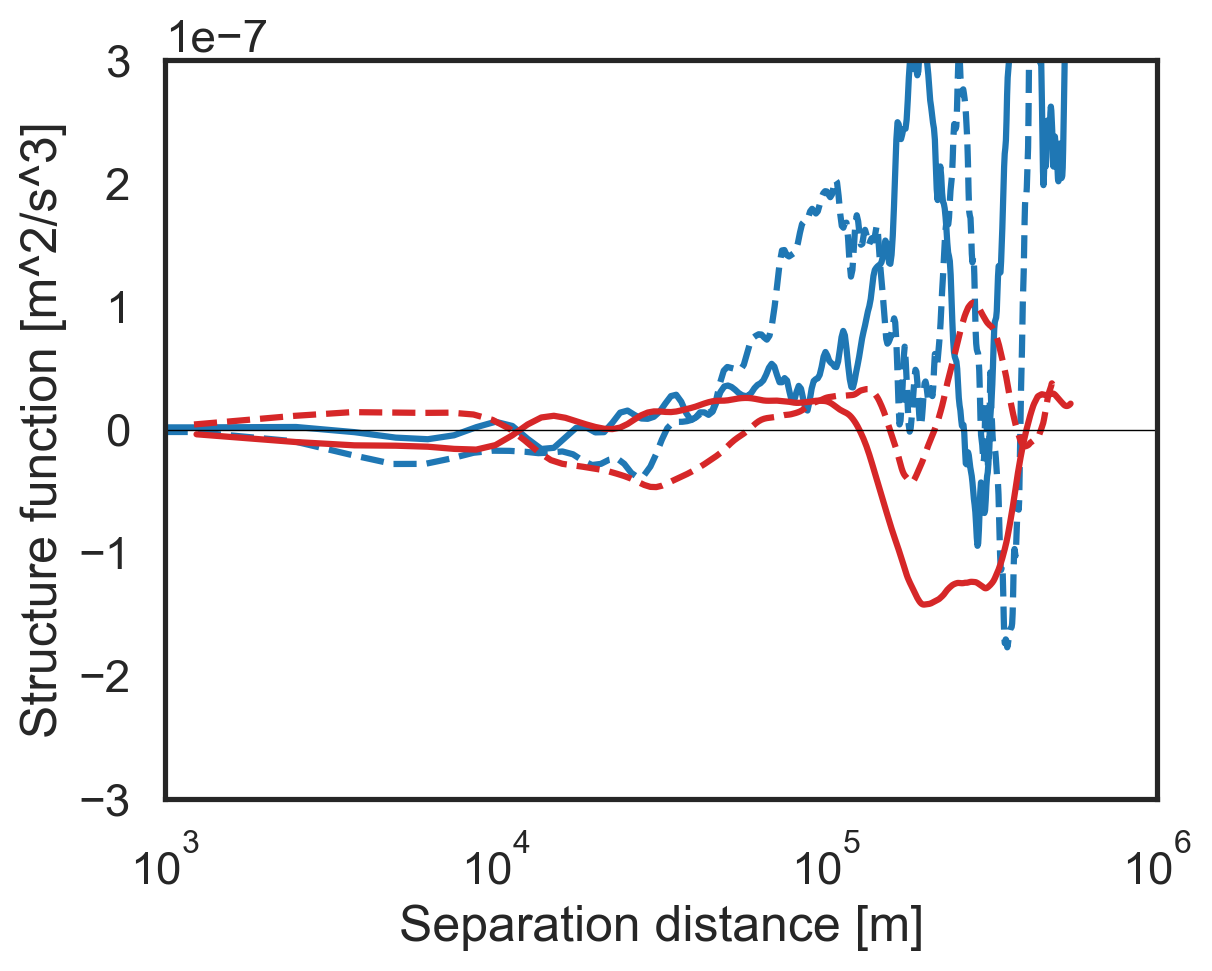

In [85]:
plt.semilogx(
    sf_geostrophic_uniform["x-diffs"],
    -sf_geostrophic_uniform["SF_advection_velocity_x"] / 2,
    color="tab:blue",
)
plt.semilogx(
    sf_geostrophic_uniform["y-diffs"],
    -sf_geostrophic_uniform["SF_advection_velocity_y"] / 2,
    color="tab:blue",
    linestyle="--",
)
plt.semilogx(
    sf_geostrophic_uniform["x-diffs"],
    -2 * sf_geostrophic_uniform["SF_LLL_x"] / (3 * sf_geostrophic_uniform["x-diffs"]),
    color="tab:red",
)
plt.semilogx(
    sf_geostrophic_uniform["y-diffs"],
    -2 * sf_geostrophic_uniform["SF_LLL_y"] / 3 / sf_geostrophic_uniform["y-diffs"],
    color="tab:red",
    linestyle="--",
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 3e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

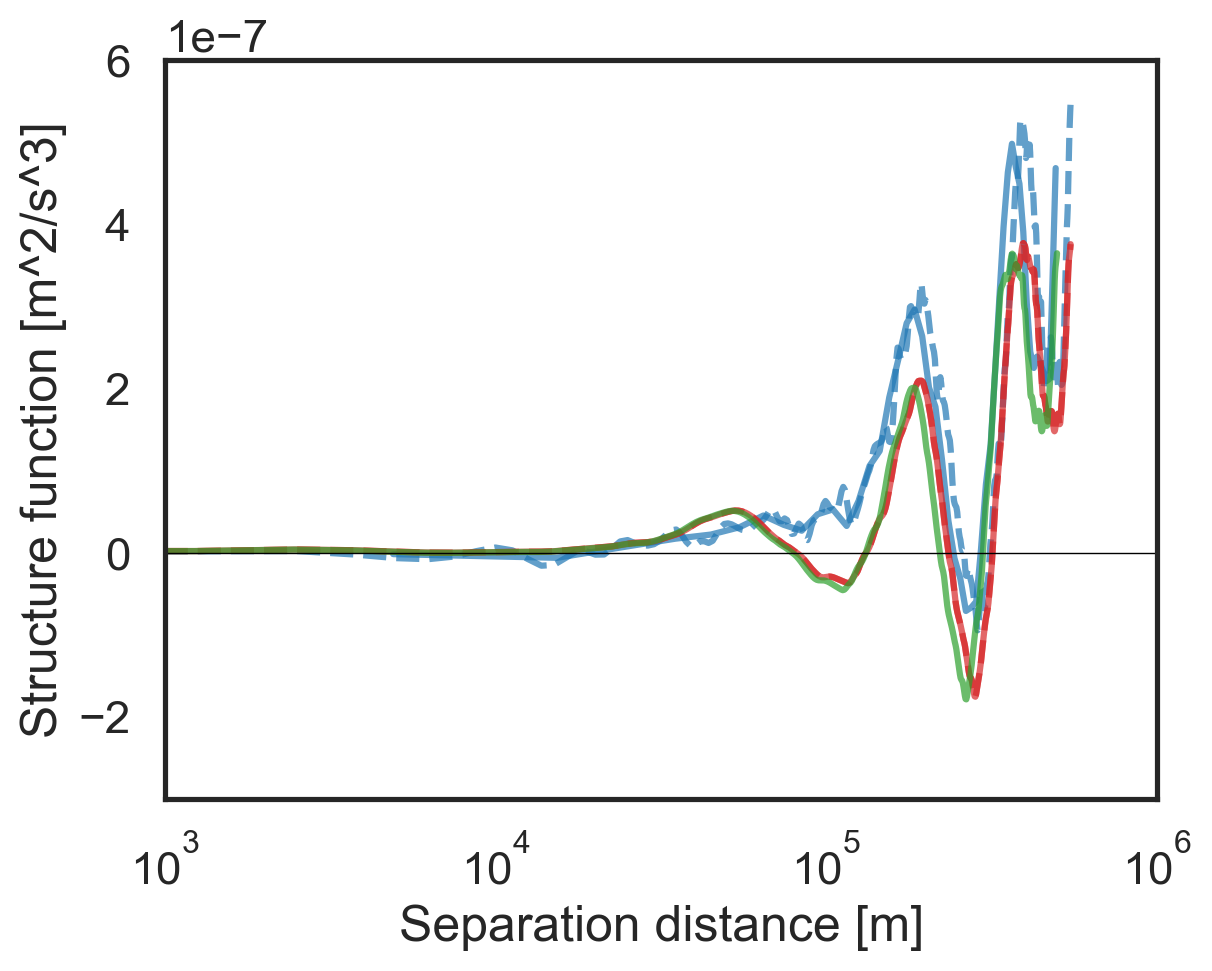

In [242]:
plt.semilogx(
    sf_geostrophic_uniform["x-diffs"],
    -sf_geostrophic_uniform["SF_advection_velocity_x"] / 2,
    color="tab:blue",
    alpha=0.7,
    linestyle="--",
)
plt.semilogx(
    sfs["x-diffs"], -sfs["SF_advection_velocity_x"] / 2, color="tab:blue",
    alpha=0.7,
)

plt.semilogx(
    sf_uniform["x-diffs"], -sf_uniform["SF_advection_velocity_x"] / 2, color="tab:red",
    alpha=0.7,
    linestyle="--",
)

plt.semilogx(
    sf_uniform_ue_vn["x-diffs"],
    -sf_uniform_ue_vn["SF_advection_velocity_x"] / 2,
    color="tab:red",
    alpha=0.7,
)

plt.semilogx(
    sf_nonuniform_uv["x-diffs"], -sf_nonuniform_uv["SF_advection_velocity_x"] / 2, color="tab:green",
    alpha=0.7,
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 6e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

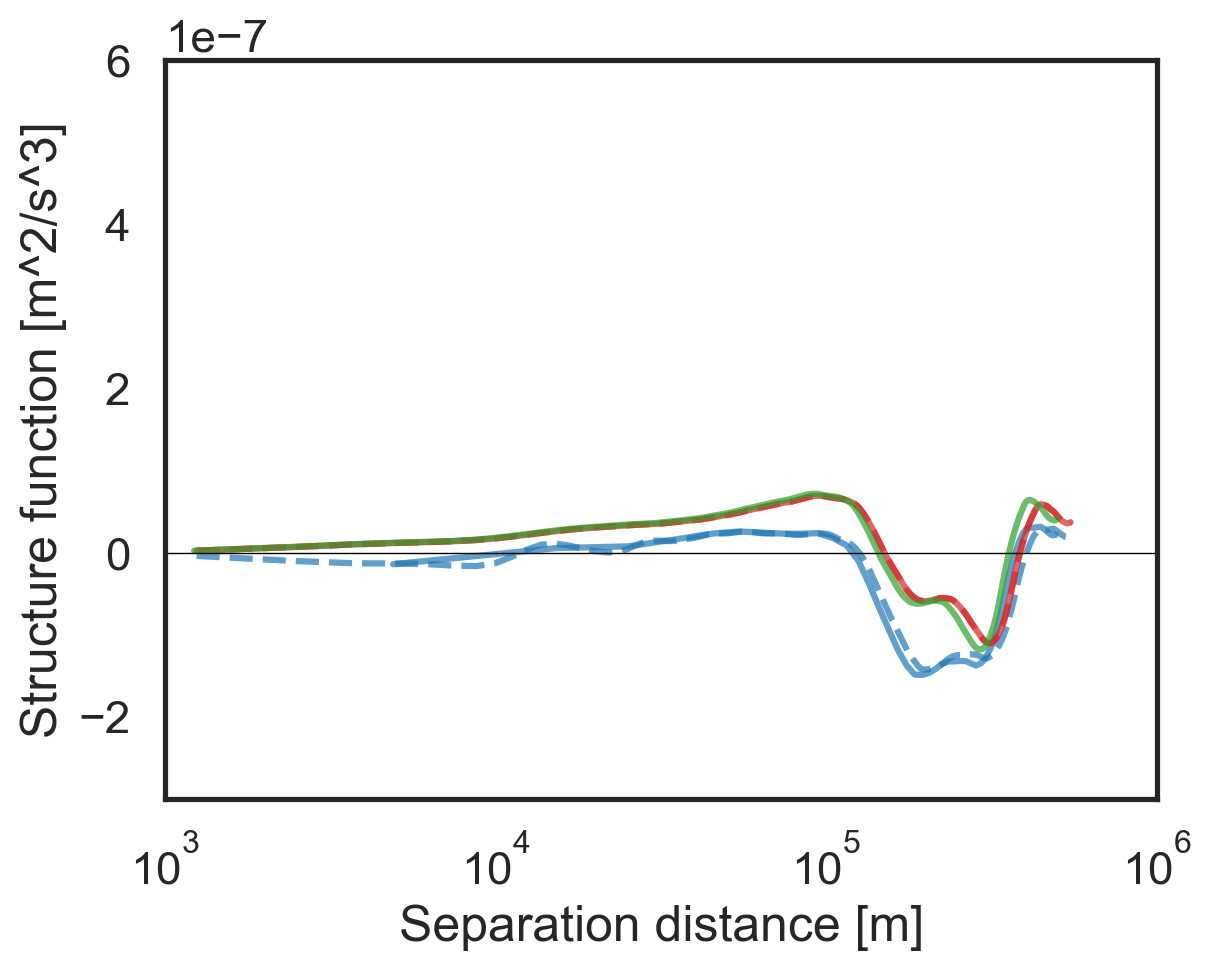

In [243]:
plt.semilogx(
    sf_geostrophic_uniform["x-diffs"],
    -2 * sf_geostrophic_uniform["SF_LLL_x"] / (3 * sf_geostrophic_uniform["x-diffs"]),
    color="tab:blue",
    alpha=0.7,
    linestyle="--",
)

plt.semilogx(
    sfs["x-diffs"],
    -2 * sfs["SF_LLL_x"] / (3 * sfs["x-diffs"]),
    color="tab:blue",
    alpha=0.7,
)

plt.semilogx(
    sf_uniform["x-diffs"],
    -2 * sf_uniform["SF_LLL_x"] / (3 * sf_uniform["x-diffs"]),
    color="tab:red",
    alpha=0.7,
    linestyle="--",
)

plt.semilogx(
    sf_uniform_ue_vn["x-diffs"],
    -2 * sf_uniform_ue_vn["SF_LLL_x"] / (3 * sf_uniform_ue_vn["x-diffs"]),
    color="tab:red",
    alpha=0.7,
)

plt.semilogx(
    sf_nonuniform_uv["x-diffs"],
    -2 * sf_nonuniform_uv["SF_LLL_x"] / (3 * sf_nonuniform_uv["x-diffs"]),
    color="tab:green",
    alpha=0.7,
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m^2/s^3]")
plt.xlim(1e3, 1e6)
plt.ylim(-3e-7, 6e-7)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)

In [153]:
lats_shift = [
    fluidsf.shift_array_1d(lats, shift_num, boundary=None) for shift_num in range(1,394)
]
lons_shift = [
    fluidsf.shift_array_1d(lons, shift_num, boundary=None) for shift_num in range(1,479)
]

In [154]:
xd_simple = [great_circle((lats_shift[0],lons[0]),(lats[0],lons[0])).meters for lats_shift in lats_shift]
yd_simple = [great_circle((lats[0],lons_shift[0]),(lats[0],lons[0])).meters for lons_shift in lons_shift]

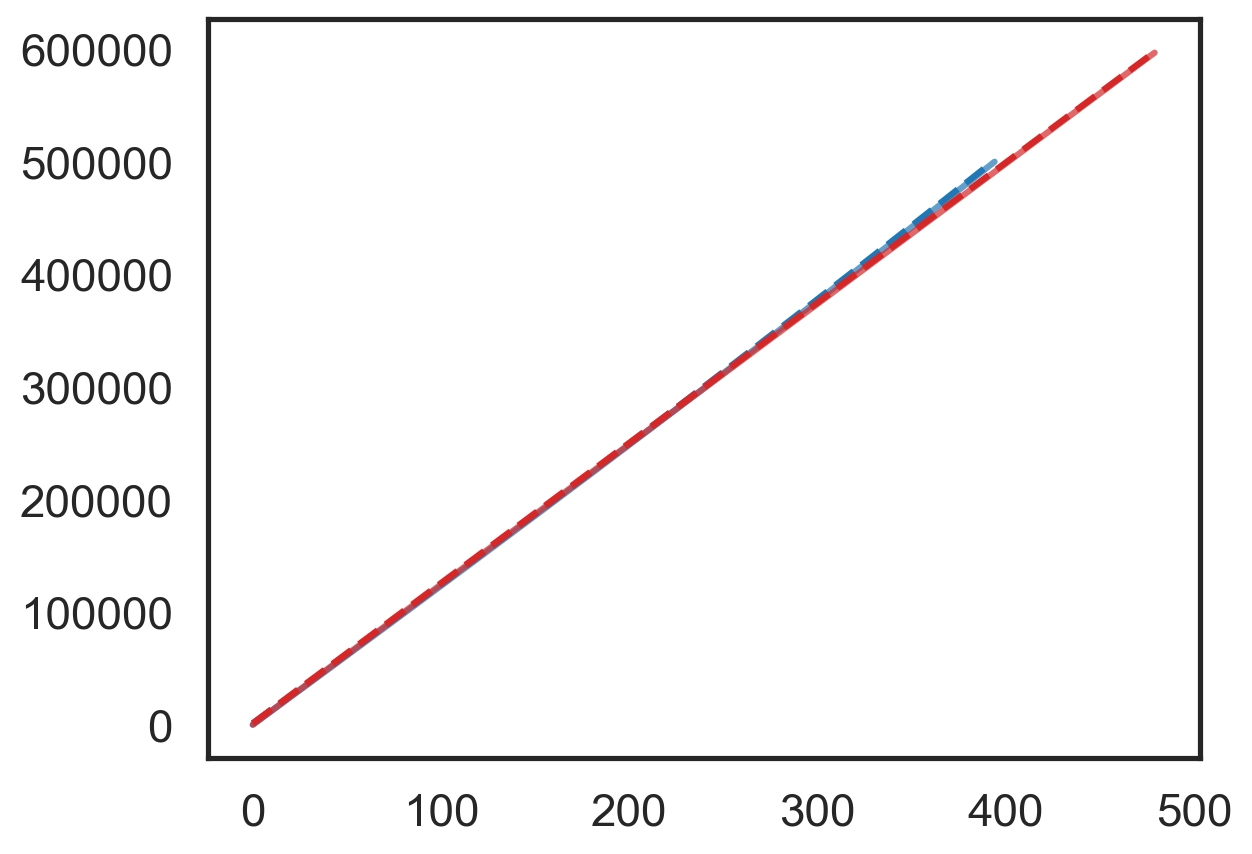

In [157]:
plt.plot(xd.cumsum(), color="tab:blue",alpha=0.7)
plt.plot(xd_simple, linestyle="--", color="tab:blue")
plt.plot(yd.cumsum(), color="tab:red",alpha=0.7)
plt.plot(yd_simple, linestyle="--", color="tab:red")

In [127]:
xd

1223.746553589733